# Image Forgery Detection; Combination of ELA -CNN

In [1]:
#libraries Importation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras import metrics
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import itertools
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Dense, Flatten,Conv2D,MaxPool2D,Dropout
from tensorflow.keras import layers, models

In [3]:
from glob import glob
from PIL import Image, ImageChops, ImageEnhance, ImageFilter
import cv2
import os

## Data Importation and Analysis

In [4]:
Dataset = glob("D:/Dataset/CASIA2/**/*")
print(len(Dataset)) # Prints total number of Authentic and tempered images all the two respective foldered contained in CASIA2 Folder

12614


In [5]:
type=set()
for file in Dataset:
    type.add(file.split(".")[-1])
print("types of files are",type) # formats of Images that make up the Dataset

types of files are {'tif', 'bmp', 'JPG', 'jpg'}


In [6]:
jpg_images=glob("D:/Dataset/CASIA2/**/*.jpg")
print('the number of jpg images are:',len(jpg_images)) # Shows total number of JPG Images (Authentic and Tampered)

the number of jpg images are: 9501


In [7]:
tif_images=glob("D:/Dataset/CASIA2/**/*.tif")
print("the number of tif images are:",len(tif_images)) # Shows total number of TIF Images (Authentic and Tampered)

the number of tif images are: 3059


In [8]:
bmp_images=glob("D:/Dataset/CASIA2/**/*.bmp")
print("the number of bmp images are:",len(bmp_images)) # Shows total number of BMP Images (Authentic and Tampered)

the number of bmp images are: 54


## Defining Error Level Analysis (ELA)

In [9]:
def convert_to_ela_image(path, quality=90, noise_reduction=True, roi=None):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    # Image Loading
    image = Image.open(path).convert('RGB')
    
    # Compressed Image Saved
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)
    
    # Computing Error Level
    ela_image = ImageChops.difference(image, temp_image)
    
    # Noise Reduction
    if noise_reduction:
        ela_image = ela_image.filter(ImageFilter.MedianFilter())
    
    if roi:
        ela_image = ela_image.crop(roi)
    
    # Normalizing the ELA image
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

### Test on Authentic Image

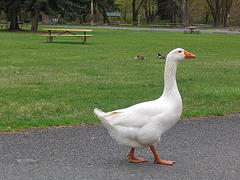

In [10]:
real_image_path=r"D:/Dataset/CASIA2/Au/Au_ani_10101.jpg"
Image.open(real_image_path) 

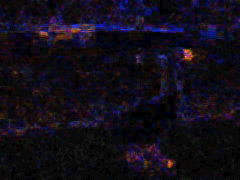

In [11]:
convert_to_ela_image(real_image_path, 90)

### Test on Tampered Image

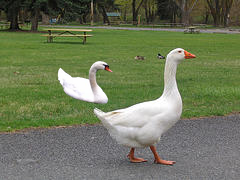

In [12]:
forged_img_path=r"D:/Dataset/CASIA2/Tp/Tp_D_CRN_M_N_ani10101_ani00081_10139.tif"
Image.open(forged_img_path)

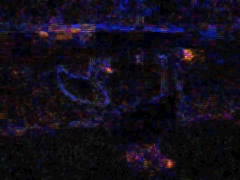

In [13]:
convert_to_ela_image(forged_img_path, 90)

In [14]:
image_size = (224, 224)

## Applying ELA on Dataset

In [15]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [16]:
X = []  
Y = [] 

In [17]:
import random
path = 'D:/Dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('tif') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 1000 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
#X = X[]
#Y = Y[]
print(len(X), len(Y))

Processing 1000 images
Processing 2000 images
Processing 3000 images
Processing 4000 images
Processing 5000 images
Processing 6000 images
Processing 7000 images
7408 7408


In [18]:
path = 'D:/Dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('tif') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 1000 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 8000 images
Processing 9000 images
Processing 10000 images
Processing 11000 images
Processing 12000 images
12531 12531


## Images conversion to Numpy Array

In [19]:
X = np.array(X)
Y = to_categorical(Y, 2) # Converting Y to categorical data
X = X.reshape(-1, 224, 224, 3)

## Splitting dataset to Training and Validation set

In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

10024 10024
2507 2507


#                                   APPROACH 1- ELA-CNN   

In [21]:
# Feeding the ELA proprocessed outputs to CNN model 

## Model Building

In [22]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu', input_shape = (224, 224, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu', input_shape = (224, 224, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(224, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [23]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0         
                                                                 
 flatten (Flatten)           (None, 387200)            0         
                                                                 
 dense (Dense)               (None, 224)               86733024  
                                                        

In [24]:
epochs = 20
batch_size = 32

In [25]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

C:\Program Files\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor = 'val_Accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

## Model Training

In [28]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/20
314/314 [==============================] - 20s 46ms/step - loss: 0.4340 - accuracy: 0.8016 - val_loss: 0.3514 - val_accuracy: 0.8588
Epoch 2/20
314/314 [==============================] - 9s 28ms/step - loss: 0.3512 - accuracy: 0.8604 - val_loss: 0.3080 - val_accuracy: 0.8700
Epoch 3/20
314/314 [==============================] - 9s 29ms/step - loss: 0.3015 - accuracy: 0.8776 - val_loss: 0.2772 - val_accuracy: 0.8807
Epoch 4/20
314/314 [==============================] - 9s 29ms/step - loss: 0.2541 - accuracy: 0.8949 - val_loss: 0.2907 - val_accuracy: 0.8684
Epoch 5/20
314/314 [==============================] - 9s 29ms/step - loss: 0.2208 - accuracy: 0.9076 - val_loss: 0.2447 - val_accuracy: 0.8883
Epoch 6/20
314/314 [==============================] - 9s 29ms/step - loss: 0.1823 - accuracy: 0.9220 - val_loss: 0.2660 - val_accuracy: 0.8744
Epoch 7/20
314/314 [==============================] - 9s 29ms/step - loss: 0.1693 - accuracy: 0.9277 - val_loss: 0.2136 - val_accuracy: 0.903

## Performance Evaluation

In [29]:
loss,accuracy=model.evaluate(X_val, Y_val)

79/79 [==============================] - 1s 10ms/step - loss: 0.3024 - accuracy: 0.8971


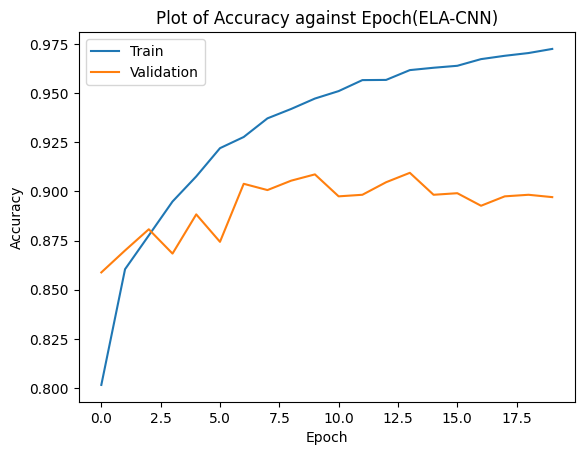

In [30]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Plot of Accuracy against Epoch(ELA-CNN)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

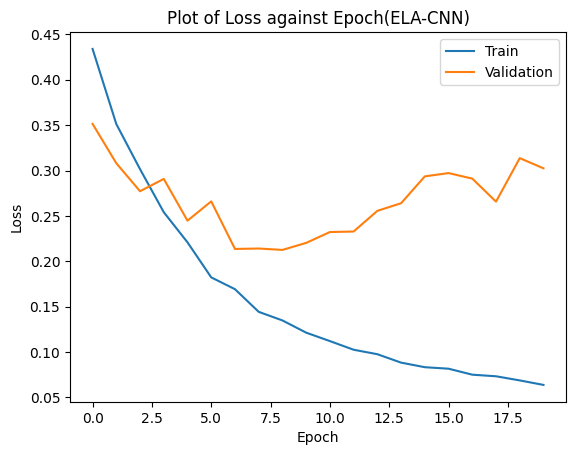

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Plot of Loss against Epoch(ELA-CNN)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])
plt.show()

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix(ELA-CNN)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

79/79 [==============================] - 1s 10ms/step


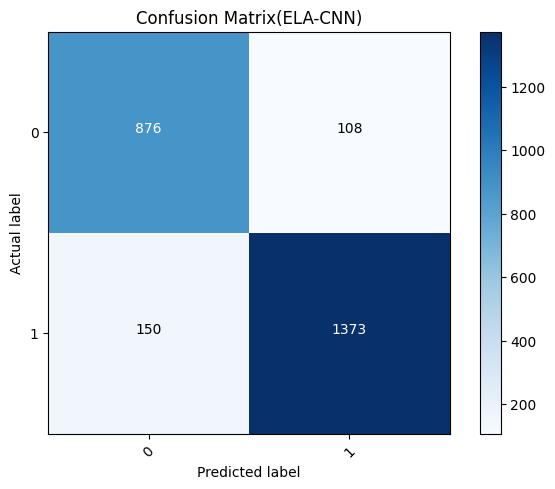

In [33]:
# Predicting values from validation set
Y_pred = model.predict(X_val) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plotting confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

## Prediction

In [34]:
class_names = ['tampered', 'authentic']

In [35]:
authentic_image_path = 'D:/Dataset/CASIA2/Au/Au_ani_10101.jpg'
image = prepare_image(authentic_image_path)
image = image.reshape(-1, 224, 224, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 47ms/step
Class: authentic Confidence: 80.95


In [36]:
tampered_image_path = 'D:/Dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
image = prepare_image(tampered_image_path)
image = image.reshape(-1, 224, 224, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 0s/step
Class: tampered Confidence: 100.00


In [37]:
tampered_image = os.listdir('D:/Dataset/CASIA2/Tp/')
correct = 0
total = 0
for file_name in tampered_image:
    if file_name.endswith('jpg') or filename.endswith('tif') or filename.endswith('bmp'):
        tampered_image_path = os.path.join('D:/Dataset/CASIA2/Tp/', file_name)
        image = prepare_image(tampered_image_path)
        image = image.reshape(-1, 224, 224, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 0s/step


In [38]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 5123, Correct: 4991, Acc: 97.42338473550653


In [40]:
authentic_image = os.listdir('D:/Dataset/CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in authentic_image:
    if file_name.endswith('jpg') or filename.endswith('tif') or filename.endswith('bmp'):
        authentic_image_path = os.path.join('D:/Dataset/CASIA2/Au/', file_name)
        image = prepare_image(authentic_image_path)
        image = image.reshape(-1, 224, 224, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


In [41]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7491, Correct: 7154, Acc: 95.50126818849286
Total: 12614, Correct: 12145, Acc: 96.2819089900111


## Checking other performance metrices

In [42]:
METRICS = [
    tf.keras.metrics.Accuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='Precision'),
    tf.keras.metrics.Recall(name='Recall'),
    tf.keras.metrics.AUC(name='AUC'),
    tf.keras.metrics.CategoricalAccuracy(name='CategoricalAccuracy'),
    tf.keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
    
]

In [43]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=METRICS)

In [44]:
early_stopping = EarlyStopping(monitor = 'val_Accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [45]:
hist = model.fit(X_train, Y_train, batch_size = 32, epochs = 20, validation_data = (X_val, Y_val)) #callbacks = [early_stopping])

Epoch 1/20
314/314 [==============================] - 14s 42ms/step - loss: 0.0569 - Accuracy: 0.2943 - Precision: 0.9762 - Recall: 0.9762 - AUC: 0.9979 - CategoricalAccuracy: 0.9762 - BinaryAccuracy: 0.9762 - val_loss: 0.3401 - val_Accuracy: 0.2776 - val_Precision: 0.8959 - val_Recall: 0.8959 - val_AUC: 0.9341 - val_CategoricalAccuracy: 0.8959 - val_BinaryAccuracy: 0.8959
Epoch 2/20
314/314 [==============================] - 10s 31ms/step - loss: 0.0555 - Accuracy: 0.3080 - Precision: 0.9772 - Recall: 0.9772 - AUC: 0.9978 - CategoricalAccuracy: 0.9772 - BinaryAccuracy: 0.9772 - val_loss: 0.3388 - val_Accuracy: 0.2575 - val_Precision: 0.8927 - val_Recall: 0.8927 - val_AUC: 0.9324 - val_CategoricalAccuracy: 0.8927 - val_BinaryAccuracy: 0.8927
Epoch 3/20
314/314 [==============================] - 10s 31ms/step - loss: 0.0532 - Accuracy: 0.3144 - Precision: 0.9788 - Recall: 0.9788 - AUC: 0.9981 - CategoricalAccuracy: 0.9788 - BinaryAccuracy: 0.9788 - val_loss: 0.3061 - val_Accuracy: 0.269

In [46]:
#Precision,Recall,AUC,CategoricalAccuracy,BinaryAccuracy=model.evaluate(X_val, Y_val)

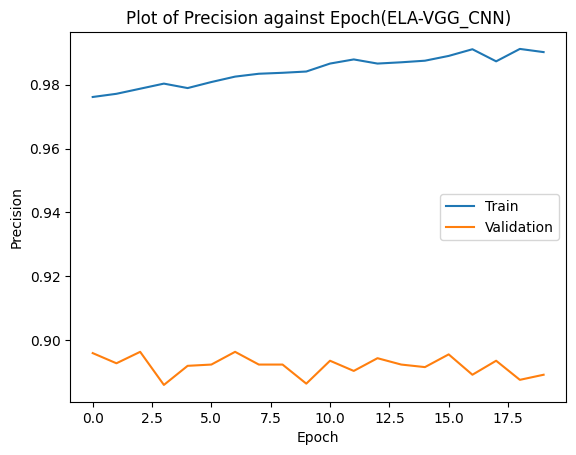

In [47]:
plt.plot(hist.history['Precision'])
plt.plot(hist.history['val_Precision'])
plt.title("Plot of Precision against Epoch(ELA-VGG_CNN)")
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train','Validation'])
plt.show()

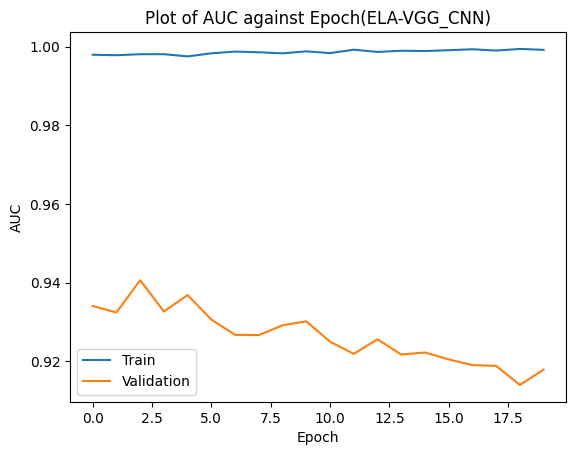

In [48]:
plt.plot(hist.history['AUC'])
plt.plot(hist.history['val_AUC'])
plt.title("Plot of AUC against Epoch(ELA-VGG_CNN)")
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train','Validation'])
plt.show()